# Stereo Matching

# Open3D Visualize in Google Colab



## 1. Install Open3D

In [ ]:
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successfully uninstalled widgetsnbextension-3.6.4
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pi

## 2. Import and Drive Mount

In [49]:
import numpy as np
import open3d as o3d
import plotly.graph_objects as go
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
%cd /content/drive/MyDrive/Stereo Matching
!ls

/content/drive/MyDrive/Stereo Matching
'Cali Images'	    'Stereo Images'	      보고서.docx
'Rectified Images'  'Stereo Matching.ipynb'


## 3. Capture Images

### Image Path

In [51]:
left_path = '/content/drive/MyDrive/Stereo Matching/Stereo Images/left.jpg'
right_path = '/content/drive/MyDrive/Stereo Matching/Stereo Images/right.jpg'

### Image Load

In [52]:
imgL = cv2.imread(left_path)
imgR = cv2.imread(right_path)

### Image Show

In [53]:
# Left Image
cv2_imshow(imgL)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Right Image
cv2_imshow(imgR)

Output hidden; open in https://colab.research.google.com to view.

### Baseline

In [54]:
baseline = 40.0 # 4cm

### Image Size

In [60]:
img_size = imgL.shape[:-1]
height = imgL.shape[0]
width = imgL.shape[1]

## 4. Calibration

provide images: img-001.jpg, ...

* nH: x 방향 cross-corner 개수
* nV: y 방향 cross-corner 개수
* nSize: 정사각형의 한 변의 길이 (mm)



In [56]:
import glob

# 패턴 정보
nH = 9
nV = 6
nSize = 18.00


#  image names
images = glob.glob("/content/drive/MyDrive/Stereo Matching/Cali Images/*.jpg")

CHECKERBOARD = (nV,nH)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# 각 체커보드 이미지에 대한 3D 점 벡터를 저장할 벡터 생성
objpoints = []
# 각 체커보드 이미지에 대한 2D 점 벡터를 저장할 벡터 생성
imgpoints = [] 
# 3D 점의 세계 좌표 정의
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2) * nSize
prev_img_shape = None

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,
                                             CHECKERBOARD,
                                             cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
        imgpoints.append(corners2)
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
    cv2_imshow(cv2.resize(img,  dsize=(0, 0), fx=0.4, fy=0.4, interpolation=cv2.INTER_LINEAR))

h,w = img.shape[:2] 
# 알려진 3D 점(objpoints) 값과 감지된 코너의 해당 픽셀 좌표(imgpoints) 전달, 카메라 캘리브레이션 수행
ret, intrinsic, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)




Output hidden; open in https://colab.research.google.com to view.

### Intrinsic matrix


In [57]:
print("Intrinsic matrix : \n")
print(intrinsic)

Intrinsic matrix : 

[[1.15014099e+03 0.00000000e+00 8.15427149e+02]
 [0.00000000e+00 1.15060853e+03 4.46585169e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### Distortion coefficient

In [58]:
print("dist : \n") # 렌즈 왜곡 계수(Lens distortion coefficients)
print(dist)

dist : 

[[ 0.08011178 -0.14944622 -0.00318952  0.00103506 -0.19737269]]


### Extrinsic parameter

In [59]:
R = np.array([[1., 0., 0.],
              [0., 1., 0.],
              [0., 0., 1.]])
T = np.array([baseline, 0., 0.])

## 5. Rectification

### Stereo Rectify
* 아래의 Matrix: 왼쪽 카메라와 오른쪽 카메라가 동일하기 때문에 각 이미지에 대한 Matrix
 * R1: 왼쪽 카메라에 대한 Rectification matrix (3x3의 Rotation matrix)
 * R2: 오른쪽 카메라에 대한 Rectification matrix (3x3의 Rotation matrix)
 * P1: 왼쪽 카메라에 대한 Translation matrix
 * P2: 오른쪽 카메라에 대한 Translation matrix
 * Q: 4x4의 Disparity to Depth Mapping matrix

* ROI(Region of Interest): 관심영역
 * roi_left: 사용 가능한 rectification 왼쪽 이미지의 영역
 * roi_right: 사용 가능한 rectification 오른쪽 이미지의 영역


In [61]:
R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(intrinsic, dist, intrinsic, dist, img_size, R, T)

### Undistortion
각 Image는 왜곡되어 있기 때문에 undistortion하고 rectification transform할 수 있는 matrix를 구하고 x축과 y축에 대해 rmap하여 rectified image를 생성한다.

In [62]:
# Left Image Map
leftMapX, leftMapY = cv2.initUndistortRectifyMap(intrinsic, dist, R1, P1, (width, height), cv2.CV_16SC2) # cv2.CV_8UC1
left_rectified = cv2.remap(imgL, leftMapX, leftMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

In [63]:
# Right Image Map
rightMapX, rightMapY = cv2.initUndistortRectifyMap(intrinsic, dist, R2, P2, (width, height), cv2.CV_16SC2) # cv2.CV_8UC1
right_rectified = cv2.remap(imgR, rightMapX, rightMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

### Image Show

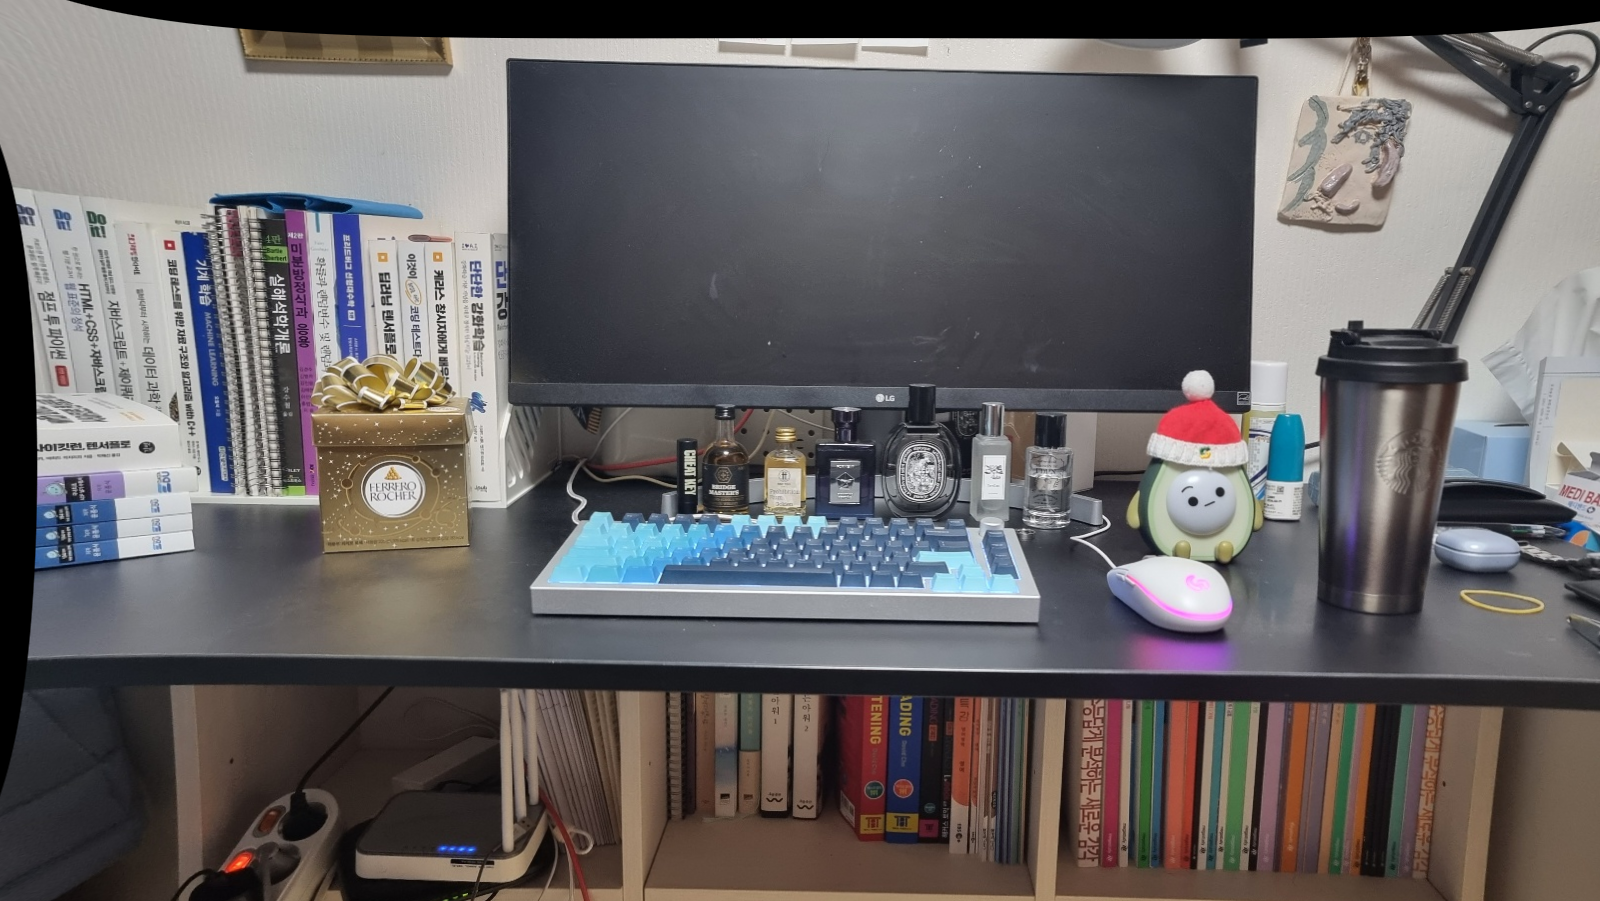

In [64]:
# Left Image
cv2_imshow(left_rectified)

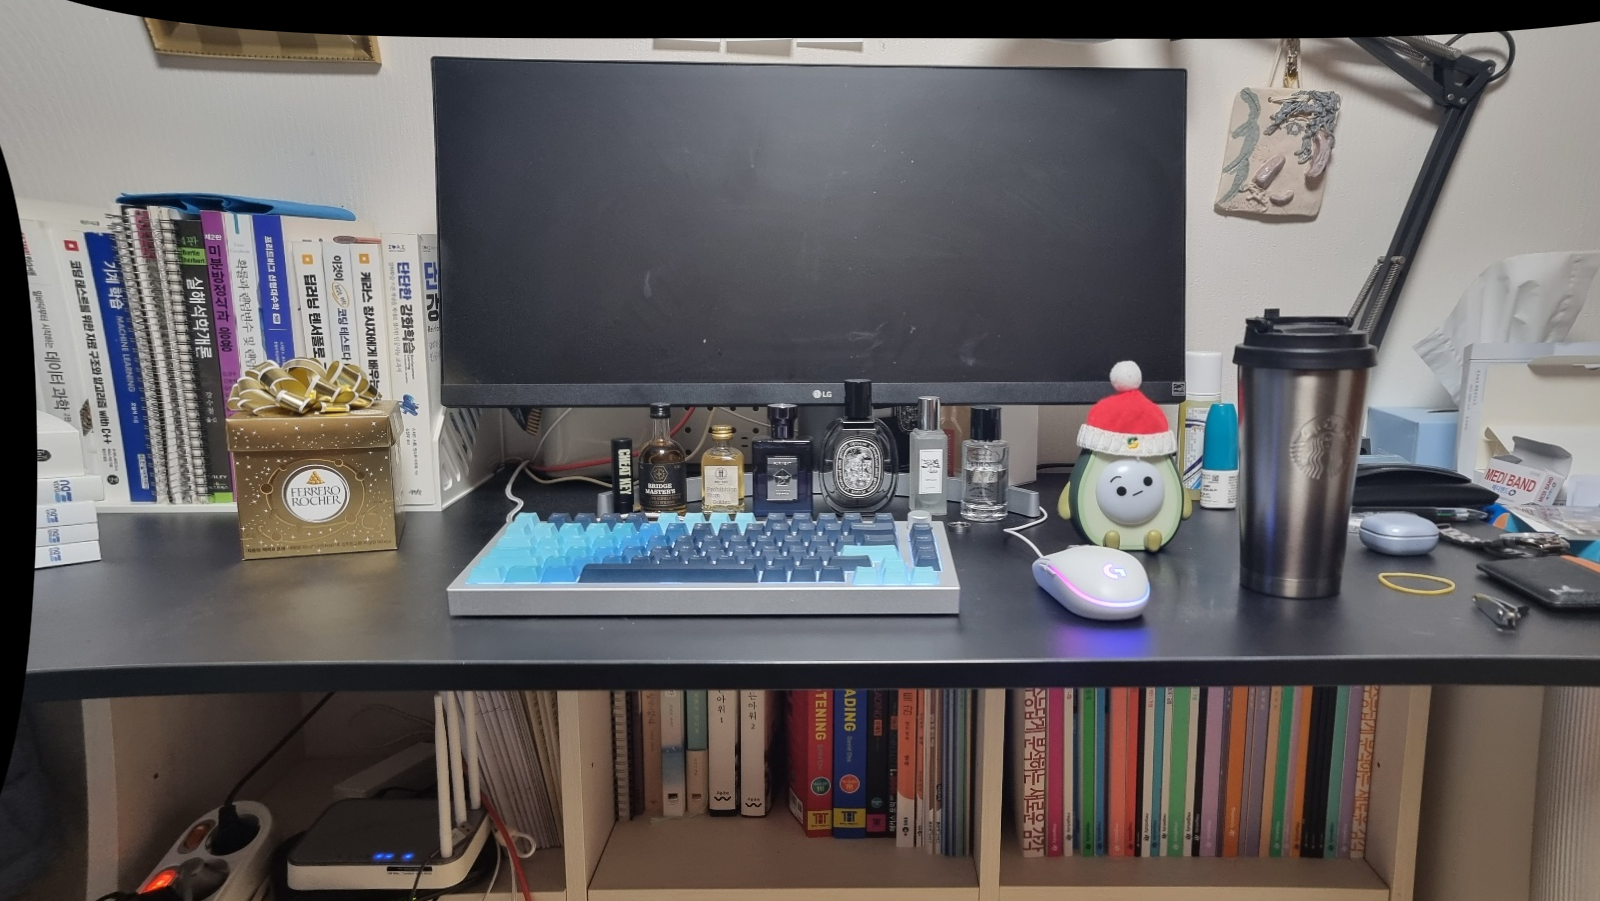

In [65]:
# Right Image
cv2_imshow(right_rectified)

## 6. Stereo Matching

### Disparity Map

In [66]:
maxDist = 80 # Max Disparity value (16의 배수)
template_size = 15 # Size of the Matching Block (5에서 255 사이의 홀수)

In [67]:
# Convert rectified images to grayscale
left = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
right = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)

In [68]:
# Create stereoBM instance
stereo = cv2.StereoBM_create(numDisparities=maxDist, blockSize=template_size)

In [69]:
# Compute disparity
disparityMap = stereo.compute(left, right)

### Image Show

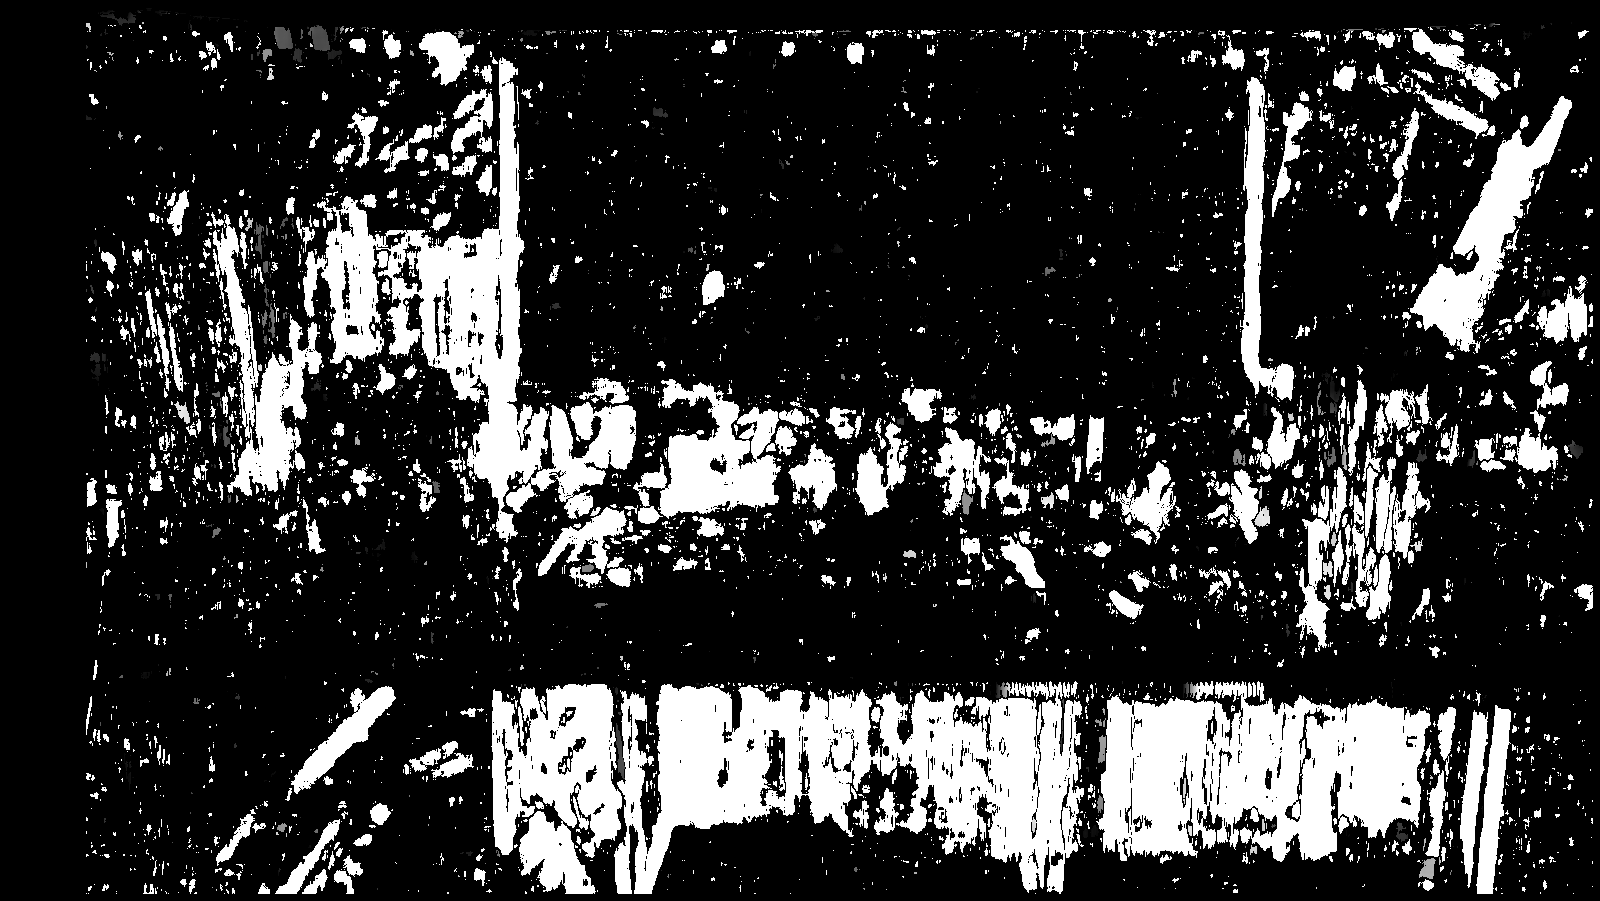

In [70]:
cv2_imshow(disparityMap)

## 7. Generate Point Clouds
* Disparity map is corresponding to left image
* For all pixels of left image, compute 3D position except
 * Disparity less than 0
 * Pixel RGB value is [0,0,0]
 * Z is more farther than threshold
* 3D position of each pixel,
 * 𝑍 = 𝐵𝑓 / 𝐷(𝑢,𝑣)
 * 𝑋 = (𝑢−𝑐𝑥) 𝑍 / 𝑓𝑥
 * 𝑌 = (𝑣−𝑐𝑦) 𝑍 / 𝑓𝑦
* Set color using RGB

In [71]:
h, w = disparityMap.shape
colors = []
points = []

f_x = intrinsic[0,0]
f_y = intrinsic[1,1]
c_x = intrinsic[0,2]
c_y = intrinsic[1,2]

threshold_Z = 70  # threshold for Z (in meters)
sampling_rate = 5

for v in range(0, h, sampling_rate):
  for u in range(0, w, sampling_rate):
    disparity = disparityMap[int(v),int(u)]
    if disparity <= 0:
      continue
    color = left_rectified[int(v),int(u), :]
    if (color == [0,0,0]).all():
      continue
    Z = baseline * f_x / disparity
    if Z > threshold_Z:
      continue
    X = (u - c_x) * Z / f_x
    Y = (v - c_y) * Z / f_y
    points.append([X,Y,Z])
    colors.append([color[2]/255.0, color[1]/255.0, color[0]/255.0])

points = np.array(points)
colors = np.array(colors)

In [72]:
# Convert to Open3D.PointCloud:
pcd_o3d = o3d.geometry.PointCloud()  # Create a point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(points)
pcd_o3d.colors=o3d.utility.Vector3dVector(colors)

## 8. Visualization
* Convert 2D Image into 3D Point Cloud

* o3d.visualization.draw_geometries() is not working inside Google Colab. So we have to Replace function to run in colab

In [73]:
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()
        
        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)
            
            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)
        
    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()
o3d.visualization.draw_geometries = draw_geometries # replace function

In [74]:
o3d.visualization.draw_geometries([pcd_o3d])